### Dynamic Range Control: Compressor

The gain computer is the compressor stage that generatesthe control voltage. The control voltage determines the gainreduction to be applied to the signal. This stage involves the Threshold $T$, Ratio $R$, and Knee Width $W$ parameters. Thesedefine the static input-to-output characteristic of compres-sion. Once the signal level exceeds the threshold value, itis attenuated according to the ratio. The compression ratio is defined as the reciprocal of theslope of the line segment above the threshold, that is:

$\begin{align*}
R &= \frac{x_{G}-T}{y_{G}-T} 
&& \text{ : } y_{G} > T \\ \tag{1}
\end{align*}$

the static compression characteristic is described by thefollowing relationship:

$\begin{align*}
Y_{G} = 
\begin{cases}
& x_{G}
&& \text{ : } x_{G} < T & \\
& T + \frac{x_{G}-T}{R}
&& \text{ : } x_{G} \geq T &\\ \tag{2}
\end{cases}
\end{align*}$

In order to smooth the transition between compression and no compression at the threshold point, we can softenthe compressor’s knee. The width $W$ of the knee (in decibels) is equally distributed on both sides of the threshold. To implement this, we replace the hard knee character-istic used in Eq. (2) with a soft knee characteristic, giving the following piecewise, continuous function,

$
Y_{G} = 
\begin{cases}
& x_{G}
&& \text{ : } x_{G} - T < \frac{-W}{2} & \\
& x_{G} + \frac{(\frac{1}{R}-1)(x_{G}-T+\frac{W}{2})^{2}}{2W}
&& \text{ : } |x_{G} - T| \leq \frac{W}{2} & \\ 
& T + \frac{x_{G}-T}{R}
&& \text{ : } x_{G} - T > \frac{W}{2} &\\ \tag{3}
\end{cases}
$

When the knee width is set to zero, the smooth knee isidentical to the hard knee.

### Dynamic Range Control: Limiter

The gain computer limits the output level when the input level exceeds the limiter threshold, all input levels above the threshold lead to a constant output level, the static limiter compression characteristic is described by thefollowing relationship:

$\begin{align*}
Y_{G} = 
\begin{cases}
& x_{G}
&& \text{ : } x_{G} < T & \\
& T
&& \text{ : } x_{G} \geq T &\\ \tag{4}
\end{cases}
\end{align*}$

same as compressor, in order to smooth the transition between limitation and no limitation at the threshold point, we can softenthe limiter’s knee. The width $W$ of the knee (in decibels) is equally distributed on both sides of the threshold. To implement this, we replace the hard knee character-istic used in Eq. (4) with a soft knee characteristic, giving the following piecewise, continuous function,

$
Y_{G} = 
\begin{cases}
& x_{G}
&& \text{ : } x_{G} - T < \frac{-W}{2} & \\
& x_{G} - \frac{(x_{G}-T+\frac{W}{2})^{2}}{2W}
&& \text{ : } |x_{G} - T| \leq \frac{W}{2} & \\ 
& T
&& \text{ : } x_{G} - T > \frac{W}{2} &\\ \tag{3}
\end{cases}
$

When the knee width is set to zero, the smooth knee isidentical to the hard knee.

In [385]:
from math import pi
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

class Dynamic_Range_Control(object):
    
    COMPRESSOR = 0
    LIMITER = 1
    NOISEGATE = 2
    CLIPPER = 3
    EXPANDER = 4
    
    def __init__(self, ratio = 16, threshold = -20, knee = 24, maximum = 20, minimum = -100):
        self._maximum = maximum
        self._minimum = minimum
        self._ratio = ratio
        self._threshold = threshold
        self._knee = knee
        
    @property
    def maximum(self):
        return self._maximum
    
    @property
    def minimum(self):
        return self._minimum
    
    @property
    def ratio(self):
        return self._ratio
    
    @property
    def threshold(self):
        return self._threshold
    
    @property
    def knee(self):
        return self._knee
    
    def generator(self):
        drc_type = 'compressor'
        
        # Xg - T < -W/2
        self.dynamic_input_range = [self.minimum, self.threshold - self.knee/2]
        self.dynamic_output_range = [self.minimum, self.threshold - self.knee/2]
        
        # |Xg - T| <= W/2
        if not self.knee == 0:
            knee_space = np.linspace(self.threshold - self.knee/2, self.threshold + self.knee/2, num=5, endpoint=True)
            if drc_type == 'limiter':
                for element in reversed(knee_space):
                    res = ((element - self.threshold + self.knee/2) ** 2) / (self.knee * 2)
                    self.dynamic_input_range.insert(2, element)
                    self.dynamic_output_range.insert(2, element-res)
            elif drc_type == 'compressor':
                for element in reversed(knee_space):
                    res = ((1/self.ratio-1)*(element - self.threshold + self.knee/2) ** 2) / (self.knee * 2)
                    self.dynamic_input_range.insert(2, element)
                    self.dynamic_output_range.insert(2, element+res)
        
        # Xg - T > W/2
        if drc_type == 'limiter':
            self.dynamic_input_range.append(self.maximum)
            self.dynamic_output_range.append(self.threshold) 
        elif drc_type == 'compressor':
            self.dynamic_input_range.append(self.maximum)
            self.dynamic_output_range.append((self.maximum-self.threshold)/self.ratio + self.threshold)
        
        print(self.dynamic_input_range)
        print(self.dynamic_output_range)


In [386]:
obj = Dynamic_Range_Control()
obj.generator()

[-100, -32.0, -32.0, -26.0, -20.0, -14.0, -8.0, 20]
[-100, -32.0, -32.0, -26.703125, -22.8125, -20.328125, -19.25, -17.5]


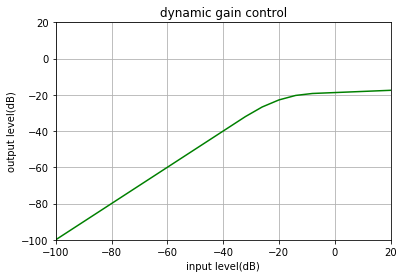

In [387]:

fig, ax1 = plt.subplots()

plt.title('dynamic gain control')
plt.ylabel('output level(dB)')
plt.xlabel('input level(dB)')

ax1.plot(obj.dynamic_input_range, obj.dynamic_output_range, 'g')
ax1.set_ylim(-100, 20)
ax1.set_xlim(-100, 20)
ax1.grid()

plt.show()